**Github commit**:
* git checkout branch
* git add filename
* git commit -m "actionname"
* git push origin

Let's start from importing **dataset**:

In [309]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('Dataset_test.csv', low_memory = False)

Then let's create two dataframes:
* The first will contain only completed orders
* The second will contain all the sessions (in which are also included the completed ones that converted into orders)

In [312]:
#Orders dataframe
orders = df.groupby(['Order_id', 'Merchant', 'Customer_id', 'Datetime', 'Country', 'Shipping Zip']).agg({
    'Blink_shipping': 'sum',
    'Cap_eligibility': 'sum',
    'Inventory_av_eligibility': 'sum',
    'New_to_blink': 'sum',
    'New_to_merch': 'sum',
    'New_to_blink': 'sum',
    'Lineitem_quantity': 'sum',
    'Lineitem_price': 'sum',
    'Shipping_price': 'max'
}).reset_index()

#Sessions dataframe
sessions = df.groupby(['Session_id', 'Merchant', 'Customer_id', 'Datetime', 'Country', 'Shipping Zip']).agg({
    'Blink_shipping': 'sum',
    'Cap_eligibility': 'sum',
    'Inventory_av_eligibility': 'sum',
    'New_to_blink': 'sum',
    'New_to_merch': 'sum',
    'New_to_blink': 'sum',
    'Lineitem_quantity': 'sum',
    'Lineitem_price': 'sum',
    'Shipping_price': 'max'
}).reset_index()

#Add time columns
orders['date'] = pd.to_datetime(orders.Datetime, errors = 'coerce', utc = 'true').dt.date
orders['day_of_week'] = pd.to_datetime(orders.Datetime, errors = 'coerce', utc = 'true').dt.day_name()
orders['hour_of_day'] = pd.to_datetime(orders.Datetime, errors = 'coerce', utc = 'true').dt.hour
orders['month_num'] = pd.to_datetime(orders.Datetime, errors = 'coerce', utc = 'true').dt.month
sessions['date'] = pd.to_datetime(sessions.Datetime, errors = 'coerce', utc = 'true').dt.date
sessions['day_of_week'] = pd.to_datetime(sessions.Datetime, errors = 'coerce', utc = 'true').dt.day_name()
sessions['hour_of_day'] = pd.to_datetime(sessions.Datetime, errors = 'coerce', utc = 'true').dt.hour
sessions['month_num'] = pd.to_datetime(sessions.Datetime, errors = 'coerce', utc = 'true').dt.month

Then the two dataframes can be filtered using to the **parameters** below:

In [348]:
country_list = ['IT']
merchant_list = ['Ketofood']
date_start = '2021-11-01'
date_end = '2022-02-01'
day_of_week_list = ['Monday', 'Tuesday']
hod_start = 1
hod_end = 24

date_start = pd.to_datetime(date_start)
date_end = pd.to_datetime(date_end)

If you don't wanna use specific filters, just **comment** the line of code (below) where that filter is. You can do that by using '#'.

In [350]:
orders_filtered = orders[
    orders.Country.isin(country_list) 
    & orders.Merchant.isin(merchant_list) 
    & (orders.date >= date_start) 
    & (orders.date < date_end) 
    & (orders.day_of_week.isin(day_of_week_list))
    & (orders.hour_of_day >= hod_start) 
    & (orders.hour_of_day < hod_end)
    ].reset_index(drop = True)

sessions_filtered = sessions
# [
#     orders.Country.isin(country_list) 
#     & orders.Merchant.isin(merchant_list) 
#     & (orders.date >= date_start) 
#     & (orders.date < date_end) 
#     & (orders.day_of_week.isin(day_of_week_list))
#     & (orders.hour_of_day >= hod_start) 
#     & (orders.hour_of_day < hod_end)
#     ].reset_index(drop = True)

C:\Users\Giuseppe\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


## From here we can compute the **KPIs**:

**1. Percentage of serviceable orders** 
<p> <i>Description</i>: number of orders where Blink is shown at checkout divided by the total number of orders </p>

,Cap_eligibility,Inventory_av_eligibility,Order_id,Percent
0,0.0,0.0,693,0.235794
1,0.0,1.0,743,0.252807
2,1.0,0.0,763,0.259612
3,1.0,1.0,740,0.251786


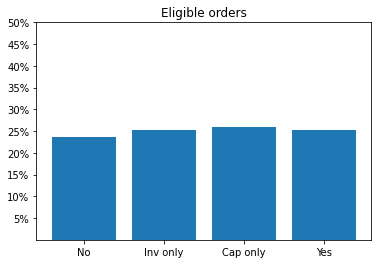

In [344]:
perc_serv_ord = orders_filtered.groupby(['Cap_eligibility', 'Inventory_av_eligibility']).Order_id.count().reset_index()
perc_serv_ord['Percent'] = perc_serv_ord.Order_id / perc_serv_ord.Order_id.sum()

display(perc_serv_ord)

ax = plt.subplot()
plt.bar(range(len(perc_serv_ord.Cap_eligibility)), perc_serv_ord.Percent)
ax.set_xticks(range(len(perc_serv_ord)))
ax.set_xticklabels(['No', 'Inv only', 'Cap only', 'Yes'])
ax.set_yticks([0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50])
ax.set_yticklabels(['5%', '10%', '15%', '20%', '25%', '30%', '35%', '40%', '45%', '50%'])
plt.title('Eligible orders')
plt.show()

**2. Percentage of turnover through Blink orders** 
<p> <i>Description</i>: revenue from Blink orders divided by the total revenue </p>

,Blink_shipping,Lineitem_price,Percent
0,0.0,52165.93,0.989995
1,1.0,527.17,0.010005


(-1.1037708390049215,
 1.1001795637621392,
 -1.1053620824390311,
 1.1022660902957815)

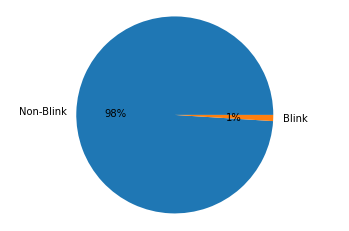

In [345]:
perc_rev = orders_filtered.groupby(['Blink_shipping']).Lineitem_price.sum().reset_index()
perc_rev['Percent'] = perc_rev.Lineitem_price / perc_rev.Lineitem_price.sum()

display(perc_rev)

plt.figure()
plt.pie(perc_rev.Lineitem_price, labels = ['Non-Blink', 'Blink'], autopct = '%d%%')
plt.axis('equal')

**3. Purchasing Frequecy ratio** 
<p> <i>Description</i>: Orders/month of customer that made more 3 orders from one merchant with Blink vs without Blink. </p>

In [346]:
customer_table = orders_filtered.groupby(['Customer_id', 'month_num', 'Blink_shipping']).Order_id.count()

display(customer_table)

Customer_id              month_num  Blink_shipping
09052012laura@gmail.com  1          0.0               2
                         11         0.0               1
1967bixio@gmail.com      12         0.0               1
1flaviamilani@gmail.com  11         0.0               2
                         12         0.0               2
                                                     ..
ziomitch@yahoo.it        1          0.0               1
ziza1976@gmail.com       1          0.0               1
zizzadolfo@gmail.com     11         0.0               1
zoilinda@gmail.com       11         0.0               1
zorzibob@yahoo.it        1          0.0               1
Name: Order_id, Length: 2608, dtype: int64

**4. Percentage increase on Conversion Rate** 
<p> <i>Description</i>: Ratio between Conversion Rate w/ Blink and Conversion Rate w/out Blink. </p>

,Blink_shown,Order_id,Session_id,conversion
0,0,950,10675,0.081720
1,1,338,3592,0.086005



Percentage increase is 0.05243069505825633


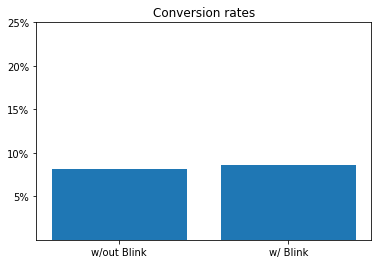

In [351]:
def f(cap, inv):
    if (cap == 1) & (inv == 1):
        return 1
    else:
        return 0

orders_new = orders_filtered
orders_new['Blink_shown'] = orders_new.apply(lambda x: f(x.Cap_eligibility, x.Inventory_av_eligibility), axis = 1)

sessions_new = sessions_filtered
sessions_new['Blink_shown'] = sessions_new.apply(lambda x: f(x.Cap_eligibility, x.Inventory_av_eligibility), axis = 1)

conversions = orders_new.groupby('Blink_shown').Order_id.count().reset_index()
totals = sessions_new.groupby('Blink_shown').Session_id.count().reset_index()
ratios = conversions.merge(totals, how = 'left')
ratios['conversion'] = ratios.Order_id / (ratios.Order_id + ratios.Session_id)

display(ratios)
print("\nPercentage increase is " + str((ratios.conversion[1] - ratios.conversion[0]) / ratios.conversion[0]))

ax = plt.subplot()
plt.bar(range(len(ratios.conversion)), ratios.conversion)
ax.set_xticks(range(len(ratios)))
ax.set_xticklabels(['w/out Blink', 'w/ Blink'])
ax.set_yticks([0.05, 0.10, 0.15, 0.20, 0.25])
ax.set_yticklabels(['5%', '10%', '15%', '20%', '25%'])
plt.title('Conversion rates')
plt.show()
